In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/sccube/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = scCube()

In [3]:
sc_data = pd.read_csv('demo_data/demo_sc_data.csv', index_col=0)
sc_meta = pd.read_csv('demo_data/demo_sc_meta.csv', index_col=0)

sc_adata = model.pre_process(sc_data=sc_data, 
                             sc_meta=sc_meta,
                             is_normalized=False)

the input is count matrix, normalizing it firstly...


In [4]:
generate_sc_meta, generate_sc_data = model.train_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num=dict(sc_meta.Cell_type.value_counts() * 3), # target number of cells to generate, if `target_num=None`, generate cells by the proportion of cell types of the input data
    batch_size=512,
    epoch_num=10000,
    lr=0.0001,
    hidden_size=128,
    save_model=False,
    used_device='cuda:1')

generating by the targeted proportion of cell types...
begin vae training...


Train Epoch: 9999: 100%|██████████| 10000/10000 [01:26<00:00, 115.71it/s, loss=0.1099, min_loss=0.1097]


vae training done!


Generate Epoch: 2: 100%|██████████| 1224/1224 [00:00<00:00, 60291.58it/s]


generated done!
data have been prepared!


In [5]:
# generate spatial patterns for each celltypes first
generate_sc_data_new, generate_sc_meta_new = model.generate_pattern_random(
    generate_sc_data=generate_sc_data,
    generate_sc_meta=generate_sc_meta,
    set_seed=True,
    seed=12345,
    spatial_cell_type=None,
    spatial_dim=2,
    spatial_size=50,
    delta=25,
    lamda=0.75,)

generating spatial coordinates of single cells...
generating spatial patterns of totally 4 cell types...


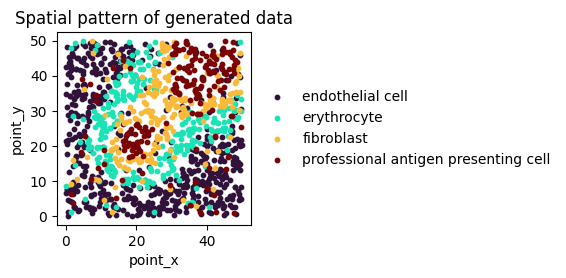

In [6]:
plot_spatial_pattern_scatter(
    obj=generate_sc_meta_new,
    figwidth=2.5,
    figheight=2.5,
    dim=2,
    x="point_x",
    y="point_y",
    label='Cell_type',
    colormap='turbo',
    size=10,
    alpha=1)
plt.show()

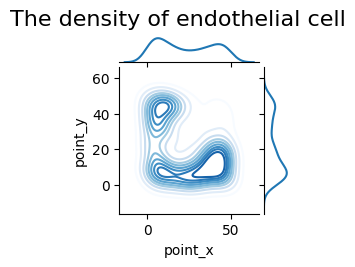

In [7]:
plot_spatial_pattern_density(
    obj=generate_sc_meta_new,
    figwidth=2.5,
    figheight=2.5,
    x="point_x",
    y="point_y",
    show_celltype='endothelial cell',
    colormap='Blues',
    label="Cell_type",
    fill=False)
plt.show()

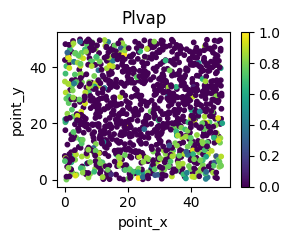

In [8]:
plot_gene_scatter(
    data=generate_sc_data_new,
    obj=generate_sc_meta_new,
    figwidth=3,
    figheight=2.5,
    dim=2,
    label='Cell',
    normalize=True,
    x="point_x",
    y="point_y",
    show_gene="Plvap",
    colormap='viridis',
    size=10,
    alpha=1)
plt.show()

In [9]:
# ST
st_data, st_meta, st_index = model.generate_spot_data_random(
    generate_sc_data=generate_sc_data_new,
    generate_sc_meta=generate_sc_meta_new,
    platform='ST',
    gene_type='whole', # `whole` -- whole genes; `hvg` -- highly variable genes; `marker` -- marker genes of each cell type; `random` -- randomly selected genes
    n_cell=30
)

generating spot-based ST data with 30 cells per spot...
generating with the spot layout and neighborhood structure of ST (square)...
generating with whole genes...


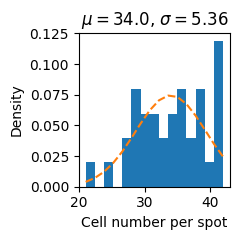

In [10]:
plot_spot_histplot(
    obj=st_index,
    figwidth=2.5,
    figheight=2.5,
    label='spot',
    n_bins=15)
plt.show()

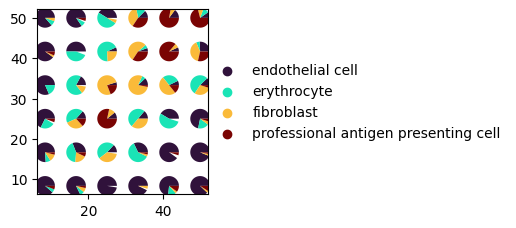

In [11]:
prop = calculate_spot_prop(
    obj=st_index,
    cell_id='Cell',
    label='Cell_type',
    spot_id='spot')

plot_spot_scatterpie(
    obj=prop,
    figwidth=2.2,
    figheight=2.4,
    x="spot_x",
    y="spot_y",
    colormap='turbo',
    res=50,
    direction="+",
    start=0.0,
    size=200,
    edgecolor="none")
plt.show()

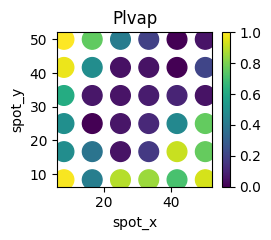

In [12]:
plot_gene_scatter(
    data=st_data,
    obj=st_meta,
    figwidth=2.8,
    figheight=2.5,
    dim=2,
    label='spot',
    normalize=True,
    x="spot_x",
    y="spot_y",
    show_gene="Plvap",
    colormap='viridis',
    size=200,
    alpha=1
)
plt.show()

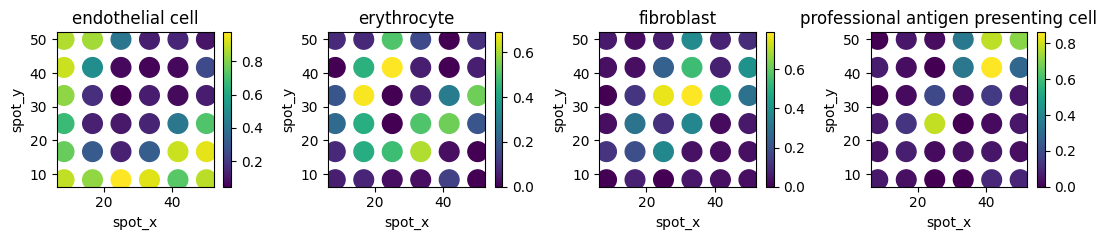

In [13]:
plot_spot_prop(
    obj=prop,
    figwidth=11,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    colormap='viridis',
    show_celltype=list(set(generate_sc_meta_new.Cell_type)),
    size=200,
    alpha=1
)
plt.show()

In [14]:
# 10X Visium
st_data, st_meta, st_index = model.generate_spot_data_random(
    generate_sc_data=generate_sc_data_new,
    generate_sc_meta=generate_sc_meta_new,
    platform='Visium',
    gene_type='whole', # `whole` -- whole genes; `hvg` -- highly variable genes; `marker` -- marker genes of each cell type; `random` -- randomly selected genes
    n_cell=10
)

generating spot-based ST data with 10 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...


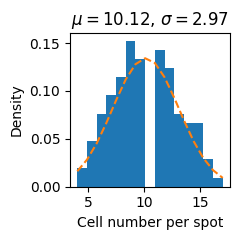

In [15]:
plot_spot_histplot(
    obj=st_index,
    figwidth=2.5,
    figheight=2.5,
    label='spot',
    n_bins=15)
plt.show()

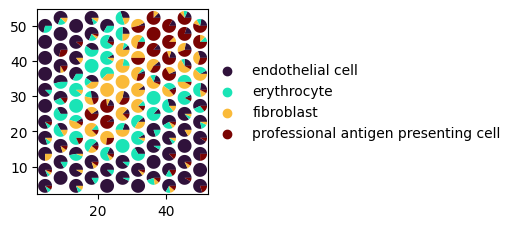

In [17]:
prop = calculate_spot_prop(
    obj=st_index,
    cell_id='Cell',
    label='Cell_type',
    spot_id='spot')

plot_spot_scatterpie(
    obj=prop,
    figwidth=2.2,
    figheight=2.4,
    x="spot_x",
    y="spot_y",
    colormap='turbo',
    res=50,
    direction="+",
    start=0.0,
    size=100,
    edgecolor="none")
plt.show()

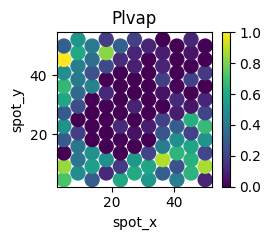

In [19]:
plot_gene_scatter(
    data=st_data,
    obj=st_meta,
    figwidth=2.8,
    figheight=2.5,
    dim=2,
    label='spot',
    normalize=True,
    x="spot_x",
    y="spot_y",
    show_gene="Plvap",
    colormap='viridis',
    size=100,
    alpha=1
)
plt.show()

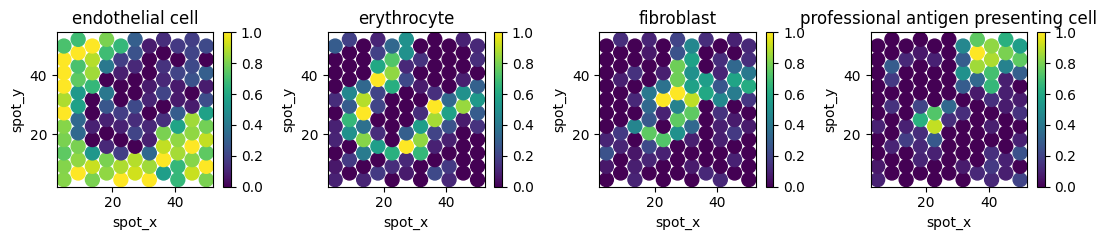

In [20]:
plot_spot_prop(
    obj=prop,
    figwidth=11,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    colormap='viridis',
    show_celltype=list(set(generate_sc_meta_new.Cell_type)),
    size=100,
    alpha=1
)
plt.show()

In [21]:
# Slide-seq
st_data, st_meta, st_index = model.generate_spot_data_random(
    generate_sc_data=generate_sc_data_new,
    generate_sc_meta=generate_sc_meta_new,
    platform='Slide',
    gene_type='whole', # `whole` -- whole genes; `hvg` -- highly variable genes; `marker` -- marker genes of each cell type; `random` -- randomly selected genes
    n_cell=2
)

generating spot-based ST data with 2 cells per spot...
generating with the spot layout and neighborhood structure of Slide-seq (random)...
generating with whole genes...


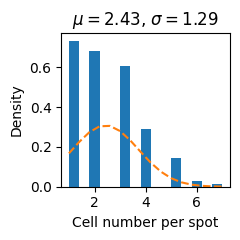

In [22]:
plot_spot_histplot(
    obj=st_index,
    figwidth=2.5,
    figheight=2.5,
    label='spot',
    n_bins=15)
plt.show()

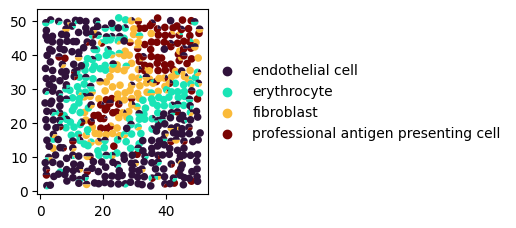

In [24]:
prop = calculate_spot_prop(
    obj=st_index,
    cell_id='Cell',
    label='Cell_type',
    spot_id='spot')

plot_spot_scatterpie(
    obj=prop,
    figwidth=2.2,
    figheight=2.4,
    x="spot_x",
    y="spot_y",
    colormap='turbo',
    res=50,
    direction="+",
    start=0.0,
    size=30,
    edgecolor="none")
plt.show()

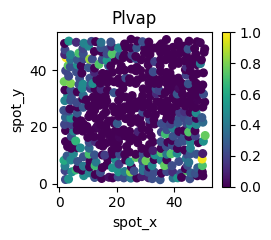

In [25]:
plot_gene_scatter(
    data=st_data,
    obj=st_meta,
    figwidth=2.8,
    figheight=2.5,
    dim=2,
    label='spot',
    normalize=True,
    x="spot_x",
    y="spot_y",
    show_gene="Plvap",
    colormap='viridis',
    size=30,
    alpha=1
)
plt.show()

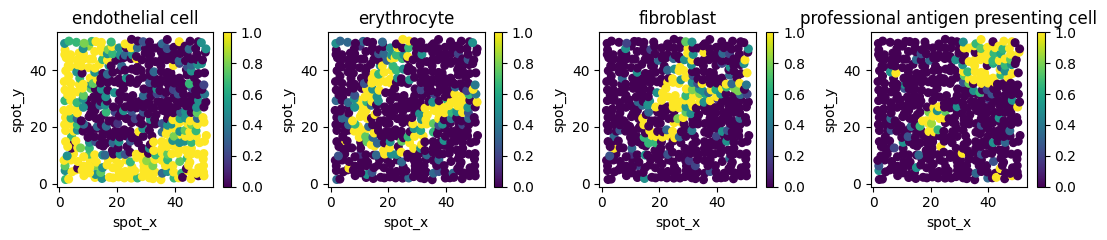

In [26]:
plot_spot_prop(
    obj=prop,
    figwidth=11,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    colormap='viridis',
    show_celltype=list(set(generate_sc_meta_new.Cell_type)),
    size=30,
    alpha=1
)
plt.show()